In [1]:
import os
import json
from typing import List, Annotated, AsyncGenerator
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama, OllamaEmbeddings

from langchain_teddynote.messages import messages_to_history
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_teddynote.evaluator import GroundednessChecker

from rag.utils import format_docs
from rag.pdf import PDFRetrievalChain

In [10]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [3]:
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain


In [13]:
retrieved_docs = pdf_retriever.invoke('문화체육활동비에 대해 알려줘.')
print(retrieved_docs[0].metadata["source"])

../rag_data/jbb/규정/(F2006) 사내근로복지기금 사무지침 [개정(14) 2022. 3.29].pdf


In [14]:
pdf.create_embedding()


HuggingFaceEmbeddings(model_name='/Users/netager/Docker_Data/openwebui-dify/rag_data/HUGGING_FACE_MODEL/BAAI_bge-m3', cache_folder=None, model_kwargs={'device': 'mps'}, encode_kwargs={'normalize_embeddings': True}, query_encode_kwargs={}, multi_process=False, show_progress=False)

In [15]:
pdf.create_vectorstore()

In [5]:
pdf.create_model()

ChatOllama(model='gemma3:12b', temperature=0.0, base_url='http://localhost:11434')

In [6]:
answer = pdf_chain.invoke(
    {
        "question": "문화체육활동비에 대해 알려줘.",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)

전 직원에게 연간 50만원 범위 내에서 체육문화활동비를 지원하며, 특정 조건(입행 후 10년 경과, 장학금 미지급, 만 45세 이상 미혼/기혼, 자녀 없음)을 충족하는 직원에게는 연 1백만원까지 지원한다. 체육문화활동의 범위는 각종 체육시설 이용, 스포츠/레저 장비 구입, 공연 관람, 도서/문화상품권 구입, 본인 및 자녀 학원비 등이 포함된다.

**Source**
- (F2006) 사내근로복지기금 사무지침 [개정(14) 2022. 3.29], page 1



In [1]:
import os
import json
from typing import List, Annotated, AsyncGenerator
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama, OllamaEmbeddings
from dotenv import load_dotenv

from rag.utils import format_docs
from langchain_teddynote.messages import messages_to_history
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_teddynote.evaluator import GroundednessChecker
from langgraph.checkpoint.memory import MemorySaver

# Carrega as variáveis do arquivo .env
load_dotenv()

from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

# Obtém a chave da API do ambiente
api_key = os.getenv("OPENAI_API_KEY")

class State(TypedDict):
    question: Annotated[str, "Question"]  # 질문(누적되는 list)
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]  # 관련성
    # messages: Annotated[list, add_messages]


# 문서 검색 노드
def retrieve_document(state: State) -> State:
    # print(f"[langgraph_agent_jb.py] state : {state['messages']}")        

    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return State(context=retrieved_docs)

        
def llm_answer(state: State) -> State:
    latest_question = state["question"]
    context = state["context"]

    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)]
    }
    return {"messages": [response]}        
    
    # return {"messages": [llm.invoke(state["messages"])]}

# 그래프 정의
graph_builder = StateGraph(State)

# 노드 정의
graph_builder.add_node("retrieve", retrieve_document)
graph_builder.add_node("llm_answer", llm_answer)

# 엣지 정의
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "llm_answer")
graph_builder.add_edge("llm_answer", END)

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
graph = graph_builder.compile()

/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


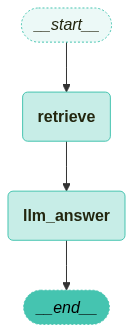

In [2]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = State(question="정보보호위원회 위원은?")

# 그래프 실행
invoke_graph(graph, inputs, config)

TypeError: invoke_graph() missing 1 required positional argument: 'config'

In [10]:
def stream_graph(
    graph: CompiledStateGraph,
    inputs: dict,
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable = None,
):
    """
    LangGraph의 실행 결과를 스트리밍하여 출력하는 함수입니다.

    Args:
        graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
        inputs (dict): 그래프에 전달할 입력값 딕셔너리
        config (RunnableConfig): 실행 설정
        node_names (List[str], optional): 출력할 노드 이름 목록. 기본값은 빈 리스트
        callback (Callable, optional): 각 청크 처리를 위한 콜백 함수. 기본값은 None
            콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    Returns:
        None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    for chunk_msg, metadata in graph.stream(inputs, config, stream_mode="messages"):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 있는 경우에만 처리
        if not node_names or curr_node in node_names:
            # 콜백 함수가 있는 경우 실행
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            # 콜백이 없는 경우 기본 출력
            else:
                # 노드가 변경된 경우에만 구분선 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 50)
                    print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
                    print("- " * 25)
                print(chunk_msg.content, end="", flush=True)

            prev_node = curr_node

stream_graph(graph, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
정보보호위원회의 위원 구성은 다음과 같습니다:

1. **위원장**: 정보보호최고책임자(CISO)
2. **부위원장**: 정보보호 부서장
3. **위원**: IT부서장, 디지털 부서장, 준법 부서장
4. **위촉위원**: 심의사항 관련 부서 담당 본부장 및 부, 실, 팀장 중에서 위원장이 선임하는 위원
5. **간사**: 정보보호 부서장

이 구성은 정보보호위원회가 효율적으로 운영되도록 하기 위한 것입니다. 위원장은 위원회를 대표하고, 위원회의 업무를 총괄합니다. 

이 정보는 전북은행의 정보보호위원회 지침(D2010)에서 발췌한 것입니다.

In [ ]:
async for event in graph.astream(input=inputs, stream_mode="messages"):
    print(f"\nReceived event: {event}\n")
    # get first element of tuple
    # message = message_chunk_to_message(event[0])
    # print(f"\nConverted event: {message}\n")


In [22]:
from langchain_core.documents import Document
from rag.utils import format_docs
from rag.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain().create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

latest_question = "전산운영위원회 위원에 대해 알려줘."
retrieved_docs = pdf_retriever.invoke(latest_question)

retrieved_docs = format_docs(retrieved_docs)

print(f"retrieved_docs: {retrieved_docs}")


results = []
for i in range(3):
    results.append(Document(
                    page_content=f"Hello, world! {i}",
                    metadata={"source": f"https://example.com_{i}"}))

print(type(results[0]))

test = format_docs(results)
# string_result = "\n".join(results)
# print(type(string_result), string_result)
# l = ['a', 'b', 'c']
# s = "\n".join(l)
# s.split("\n")



retrieved_docs: <document><content>전산운영위원회 지침 D2009 - 1 -전산운영위원회 지침 소관부서 : IT기획부 제 1 조 (목적) 이 지침은 위원회규정 제13조에 따라 전산운영위원회 (이하 ｢위원회 ｣라 한다) 의 운영에 필요한 사항을 정함으로써 전산운영의 효율적 추진을 목적으로 한다.
제 2 조 (구성) ① 위원회는 다음과 같이 구성한다 .
1. 상임위원 : 전산담당임원 , 종합기획부장 , 인사지원부장 , 마케팅기획부장 , 준법감시부장 ,            IT기획부장 , IT개발부장 , 정보보호부장 , 디지털플랫폼부장 (2022. 8. 8 개정) 2. 위촉위원 : 심의사항 관련부서 담당본부장 및 부･실장 중에서 위원장이 선임하는 자  ② 위원회의 위원장은 전산담당본부장이 되며 위원장이 유고시 직무를 수행할 수 없을 때 에는 IT기획부장이 대행한다 . (2018. 7.11 개정)

문서 : 전북은행 (D2009) 전산운영위원회지침 [개정(11) 2024. 6. 5]</content><source>../rag_data/jbb/규정/(D2009) 전산운영위원회지침 [개정(11) 2024. 6. 5].pdf</source><page>1</page></document>
<document><content>전산운영위원회 지침 D2009 - 2 -1. 실무협의회 위원은 IT기획부장 , IT기획부 기획팀장 ,종합기획부 ･인사지원부 ･마케팅기획 부･준법감시부 ･IT개발부 ･정보보호부 ･디지털플랫폼부의 담당책임자로 구성한다 .(2022.  8. 8. 개정) 2. 실무협의회의 의장은 IT기획부장 , 부의장은 IT기획부 기획담당 부부장이 된다. (2018.  7.11 개정) 3. 각 부,실의 위원은 실무협의회 역할에 부합하는 업무를 담당하고 있는 책임자로 위원 장이 임명한다 .
4. 실무협의회의 간사는 IT기획부 기획담당 책임자가 된다. (2018. 7.11 개정) 5. 위원장이 필요하다고 인정하는 경우 안건과 관련 있는 사업담당 및 관련부서 

KeyError: 'page'